# Models Comparison for TinyML

In [20]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs

warnings.filterwarnings('ignore')

In [21]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [22]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [23]:
print(X.shape)

(1400, 5)


In [24]:
X = np.concatenate((X[:200], X[600:800], X[1200:]), axis=0)
y = np.concatenate((y[:200], y[600:800], y[1200:]), axis=0)

In [25]:
# Convert the labels in values like 0...n for the NN tests

labels = []
uniques = list(np.unique(y))

[labels.append(uniques.index(el)) for el in y]

y = np.array(labels)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [27]:
print(y_test)

[0 0 1 2 1 1 1 1 2 0 0 2 2 0 0 0 2 2 1 1 0 1 2 1 2 2 2 0 2 2 1 1 0 1 0 2 0
 1 2 1 1 0 0 1 0 2 0 0 0 2 1 1 0 2 0 2 2 1 1 1 0 1 1 2 2 2 0 2 1 2 1 2 1 1
 2 0 2 0 2 2 1 0 1 0 1 0 0 2 0 0 1 1 2 1 2 2 1 0 2 0 1 2 1 0 1 0 0 2 1 0 0
 1 0 1 0 2 0 2 2 2]


## Model Spotting

In [28]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [29]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [30]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,72 0,05
LR - 0,74 0,05
CART - 0,94 0,04
SVC - 0,91 0,04
RF - 0,94 0,03


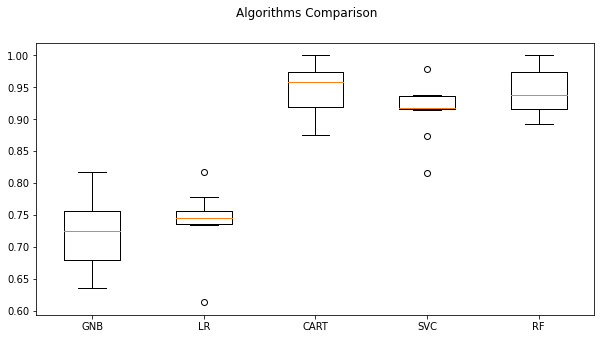

In [31]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione modelli sul Test Set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
#scaler = RobustScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           1       0.59      0.80      0.68        40
           2       0.81      0.72      0.76        40

    accuracy                           0.75       120
   macro avg       0.79      0.75      0.76       120
weighted avg       0.79      0.75      0.76       120

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.97      0.70      0.81        40
           1       0.58      0.80      0.67        40
           2       0.81      0.72      0.76        40

    accuracy                           0.74       120
   macro avg       0.78      0.74      0.75       120
weighted avg       0.78      0.74      0.75       120

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.93

# Valutazione Inferance Rate medio (|X_test| = 100)

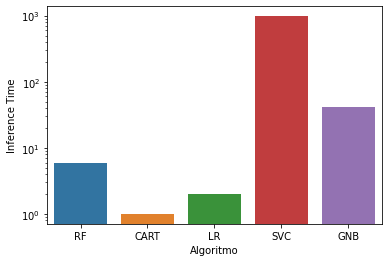

In [33]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

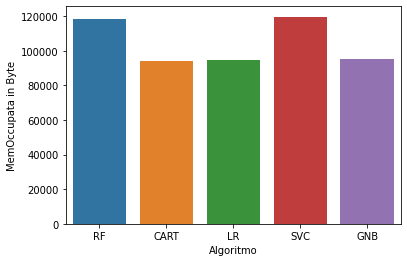

In [34]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [35]:
learn_rate = 0.001
def getNetwork(): 
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [36]:
EPOCHS = 500
BATCH_SIZE = 5
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
87/87 [==============================] - 0s 442us/step - loss: 0.8765 - accuracy: 0.7222
Epoch 2/500
87/87 [==============================] - 0s 433us/step - loss: 0.6390 - accuracy: 0.7778
Epoch 3/500
87/87 [==============================] - 0s 419us/step - loss: 0.5630 - accuracy: 0.7847
Epoch 4/500
87/87 [==============================] - 0s 435us/step - loss: 0.5

87/87 [==============================] - 0s 444us/step - loss: 0.2693 - accuracy: 0.8889
Epoch 75/500
87/87 [==============================] - 0s 458us/step - loss: 0.2715 - accuracy: 0.8819
Epoch 76/500
87/87 [==============================] - 0s 473us/step - loss: 0.2752 - accuracy: 0.8843
Epoch 77/500
87/87 [==============================] - 0s 467us/step - loss: 0.2731 - accuracy: 0.8796
Epoch 78/500
87/87 [==============================] - 0s 476us/step - loss: 0.2824 - accuracy: 0.8843
Epoch 79/500
87/87 [==============================] - 0s 464us/step - loss: 0.2810 - accuracy: 0.8866
Epoch 80/500
87/87 [==============================] - 0s 444us/step - loss: 0.2715 - accuracy: 0.8866
Epoch 81/500
87/87 [==============================] - 0s 484us/step - loss: 0.2745 - accuracy: 0.8843
Epoch 82/500
87/87 [==============================] - 0s 462us/step - loss: 0.2842 - accuracy: 0.8912
Epoch 83/500
87/87 [==============================] - 0s 477us/step - loss: 0.2739 - accuracy: 

KeyboardInterrupt: 

# Train and Test

In [37]:
EPOCHS = 750
BATCH_SIZE = 5

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred))

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/750
72/72 [==============================] - 0s 1ms/step - loss: 5.8084 - accuracy: 0.3972 - val_loss: 3.8929 - val_accuracy: 0.4417
Epoch 2/750
72/72 [==============================] - 0s 631us/step - loss: 2.9710 - accuracy: 0.4472 - val_loss: 1.3937 - val_accuracy: 0.4500
Epoch 3/750
72/72 [==============================] - 0s 631us/step - loss: 2.1239 - accuracy: 0.4

Epoch 53/750
72/72 [==============================] - 0s 614us/step - loss: 0.7034 - accuracy: 0.7000 - val_loss: 0.6512 - val_accuracy: 0.7250
Epoch 54/750
72/72 [==============================] - 0s 619us/step - loss: 0.6725 - accuracy: 0.7167 - val_loss: 0.6118 - val_accuracy: 0.7417
Epoch 55/750
72/72 [==============================] - 0s 615us/step - loss: 0.6856 - accuracy: 0.6861 - val_loss: 0.7057 - val_accuracy: 0.7417
Epoch 56/750
72/72 [==============================] - 0s 607us/step - loss: 0.6927 - accuracy: 0.7028 - val_loss: 0.6690 - val_accuracy: 0.7250
Epoch 57/750
72/72 [==============================] - 0s 630us/step - loss: 0.6694 - accuracy: 0.7250 - val_loss: 0.6584 - val_accuracy: 0.7250
Epoch 58/750
72/72 [==============================] - 0s 646us/step - loss: 0.6472 - accuracy: 0.7028 - val_loss: 0.6212 - val_accuracy: 0.6667
Epoch 59/750
72/72 [==============================] - 0s 612us/step - loss: 0.6930 - accuracy: 0.7083 - val_loss: 0.6017 - val_accuracy:

Epoch 110/750
72/72 [==============================] - 0s 600us/step - loss: 0.5401 - accuracy: 0.7472 - val_loss: 0.5460 - val_accuracy: 0.7000
Epoch 111/750
72/72 [==============================] - 0s 623us/step - loss: 0.5388 - accuracy: 0.7306 - val_loss: 0.6265 - val_accuracy: 0.7750
Epoch 112/750
72/72 [==============================] - 0s 629us/step - loss: 0.5939 - accuracy: 0.7528 - val_loss: 0.5045 - val_accuracy: 0.8000
Epoch 113/750
72/72 [==============================] - 0s 603us/step - loss: 0.5887 - accuracy: 0.7472 - val_loss: 0.5456 - val_accuracy: 0.7333
Epoch 114/750
72/72 [==============================] - 0s 599us/step - loss: 0.5263 - accuracy: 0.7500 - val_loss: 0.5821 - val_accuracy: 0.8250
Epoch 115/750
72/72 [==============================] - 0s 641us/step - loss: 0.5527 - accuracy: 0.7556 - val_loss: 0.4721 - val_accuracy: 0.7750
Epoch 116/750
72/72 [==============================] - 0s 622us/step - loss: 0.5749 - accuracy: 0.7389 - val_loss: 0.5696 - val_ac

72/72 [==============================] - 0s 624us/step - loss: 0.5550 - accuracy: 0.7472 - val_loss: 0.5928 - val_accuracy: 0.7917
Epoch 167/750
72/72 [==============================] - 0s 617us/step - loss: 0.5184 - accuracy: 0.7750 - val_loss: 0.4509 - val_accuracy: 0.7583
Epoch 168/750
72/72 [==============================] - 0s 603us/step - loss: 0.5749 - accuracy: 0.7833 - val_loss: 0.5557 - val_accuracy: 0.7667
Epoch 169/750
72/72 [==============================] - 0s 608us/step - loss: 0.4848 - accuracy: 0.7778 - val_loss: 0.5094 - val_accuracy: 0.7750
Epoch 170/750
72/72 [==============================] - 0s 624us/step - loss: 0.4940 - accuracy: 0.7833 - val_loss: 0.4640 - val_accuracy: 0.8167
Epoch 171/750
72/72 [==============================] - 0s 604us/step - loss: 0.5130 - accuracy: 0.7639 - val_loss: 0.4967 - val_accuracy: 0.8333
Epoch 172/750
72/72 [==============================] - 0s 592us/step - loss: 0.5061 - accuracy: 0.7944 - val_loss: 0.5416 - val_accuracy: 0.7500

72/72 [==============================] - 0s 752us/step - loss: 0.4673 - accuracy: 0.7972 - val_loss: 0.4714 - val_accuracy: 0.7833
Epoch 223/750
72/72 [==============================] - 0s 1ms/step - loss: 0.4606 - accuracy: 0.7833 - val_loss: 0.5847 - val_accuracy: 0.7167
Epoch 224/750
72/72 [==============================] - 0s 611us/step - loss: 0.4819 - accuracy: 0.7944 - val_loss: 0.4775 - val_accuracy: 0.8000
Epoch 225/750
72/72 [==============================] - 0s 599us/step - loss: 0.4867 - accuracy: 0.7972 - val_loss: 0.5442 - val_accuracy: 0.7917
Epoch 226/750
72/72 [==============================] - 0s 611us/step - loss: 0.4893 - accuracy: 0.7722 - val_loss: 0.5424 - val_accuracy: 0.8083
Epoch 227/750
72/72 [==============================] - 0s 591us/step - loss: 0.4815 - accuracy: 0.7917 - val_loss: 0.5466 - val_accuracy: 0.7500
Epoch 228/750
72/72 [==============================] - 0s 596us/step - loss: 0.4602 - accuracy: 0.7917 - val_loss: 0.5152 - val_accuracy: 0.8000
E

72/72 [==============================] - 0s 620us/step - loss: 0.4661 - accuracy: 0.8194 - val_loss: 0.5245 - val_accuracy: 0.7333
Epoch 279/750
72/72 [==============================] - 0s 604us/step - loss: 0.5421 - accuracy: 0.7417 - val_loss: 0.4830 - val_accuracy: 0.7833
Epoch 280/750
72/72 [==============================] - 0s 611us/step - loss: 0.4672 - accuracy: 0.7778 - val_loss: 0.5444 - val_accuracy: 0.7750
Epoch 281/750
72/72 [==============================] - 0s 625us/step - loss: 0.5199 - accuracy: 0.7472 - val_loss: 1.0142 - val_accuracy: 0.4583
Epoch 282/750
72/72 [==============================] - 0s 626us/step - loss: 0.5148 - accuracy: 0.7917 - val_loss: 0.4901 - val_accuracy: 0.8167
Epoch 283/750
72/72 [==============================] - 0s 613us/step - loss: 0.4583 - accuracy: 0.8167 - val_loss: 0.4541 - val_accuracy: 0.8417
Epoch 284/750
72/72 [==============================] - 0s 616us/step - loss: 0.4803 - accuracy: 0.7917 - val_loss: 0.6260 - val_accuracy: 0.7750

72/72 [==============================] - 0s 680us/step - loss: 0.4933 - accuracy: 0.7778 - val_loss: 0.4986 - val_accuracy: 0.7833
Epoch 335/750
72/72 [==============================] - 0s 606us/step - loss: 0.4856 - accuracy: 0.8000 - val_loss: 0.5140 - val_accuracy: 0.8083
Epoch 336/750
72/72 [==============================] - 0s 632us/step - loss: 0.4820 - accuracy: 0.7917 - val_loss: 0.5784 - val_accuracy: 0.7750
Epoch 337/750
72/72 [==============================] - 0s 602us/step - loss: 0.4877 - accuracy: 0.8000 - val_loss: 0.5156 - val_accuracy: 0.8083
Epoch 338/750
72/72 [==============================] - 0s 613us/step - loss: 0.4472 - accuracy: 0.8139 - val_loss: 0.6097 - val_accuracy: 0.7750
Epoch 339/750
72/72 [==============================] - 0s 616us/step - loss: 0.4641 - accuracy: 0.7944 - val_loss: 0.5603 - val_accuracy: 0.7750
Epoch 340/750
72/72 [==============================] - 0s 619us/step - loss: 0.4490 - accuracy: 0.7944 - val_loss: 0.5694 - val_accuracy: 0.7750

72/72 [==============================] - 0s 614us/step - loss: 0.4155 - accuracy: 0.8056 - val_loss: 0.5492 - val_accuracy: 0.7417
Epoch 391/750
72/72 [==============================] - 0s 613us/step - loss: 0.4608 - accuracy: 0.8167 - val_loss: 0.5455 - val_accuracy: 0.7667
Epoch 392/750
72/72 [==============================] - 0s 609us/step - loss: 0.4530 - accuracy: 0.7944 - val_loss: 0.4776 - val_accuracy: 0.7750
Epoch 393/750
72/72 [==============================] - 0s 603us/step - loss: 0.4545 - accuracy: 0.8194 - val_loss: 0.6031 - val_accuracy: 0.7750
Epoch 394/750
72/72 [==============================] - 0s 619us/step - loss: 0.4851 - accuracy: 0.7944 - val_loss: 0.6667 - val_accuracy: 0.7750
Epoch 395/750
72/72 [==============================] - 0s 606us/step - loss: 0.4838 - accuracy: 0.7944 - val_loss: 0.5750 - val_accuracy: 0.7750
Epoch 396/750
72/72 [==============================] - 0s 620us/step - loss: 0.4824 - accuracy: 0.7639 - val_loss: 0.4926 - val_accuracy: 0.8167

72/72 [==============================] - 0s 626us/step - loss: 0.4484 - accuracy: 0.8111 - val_loss: 0.5631 - val_accuracy: 0.7750
Epoch 447/750
72/72 [==============================] - 0s 584us/step - loss: 0.4306 - accuracy: 0.8139 - val_loss: 0.6518 - val_accuracy: 0.7750
Epoch 448/750
72/72 [==============================] - 0s 603us/step - loss: 0.4698 - accuracy: 0.7889 - val_loss: 0.4719 - val_accuracy: 0.8250
Epoch 449/750
72/72 [==============================] - 0s 648us/step - loss: 0.4425 - accuracy: 0.7972 - val_loss: 0.6542 - val_accuracy: 0.7750
Epoch 450/750
72/72 [==============================] - 0s 647us/step - loss: 0.4860 - accuracy: 0.7750 - val_loss: 0.6295 - val_accuracy: 0.7750
Epoch 451/750
72/72 [==============================] - 0s 644us/step - loss: 0.4679 - accuracy: 0.7972 - val_loss: 0.5185 - val_accuracy: 0.7750
Epoch 452/750
72/72 [==============================] - 0s 673us/step - loss: 0.4606 - accuracy: 0.7972 - val_loss: 0.5546 - val_accuracy: 0.8083

72/72 [==============================] - 0s 667us/step - loss: 0.4344 - accuracy: 0.7917 - val_loss: 0.5791 - val_accuracy: 0.7750
Epoch 503/750
72/72 [==============================] - 0s 694us/step - loss: 0.4224 - accuracy: 0.8083 - val_loss: 0.5362 - val_accuracy: 0.8250
Epoch 504/750
72/72 [==============================] - 0s 704us/step - loss: 0.4667 - accuracy: 0.7806 - val_loss: 0.4804 - val_accuracy: 0.8667
Epoch 505/750
72/72 [==============================] - 0s 757us/step - loss: 0.4216 - accuracy: 0.8139 - val_loss: 0.6989 - val_accuracy: 0.7333
Epoch 506/750
72/72 [==============================] - 0s 731us/step - loss: 0.4712 - accuracy: 0.8000 - val_loss: 0.5044 - val_accuracy: 0.8333
Epoch 507/750
72/72 [==============================] - 0s 778us/step - loss: 0.4381 - accuracy: 0.8028 - val_loss: 0.4656 - val_accuracy: 0.8333
Epoch 508/750
72/72 [==============================] - 0s 698us/step - loss: 0.4402 - accuracy: 0.8111 - val_loss: 0.5065 - val_accuracy: 0.7667

72/72 [==============================] - 0s 619us/step - loss: 0.4377 - accuracy: 0.8194 - val_loss: 0.6114 - val_accuracy: 0.7833
Epoch 559/750
72/72 [==============================] - 0s 611us/step - loss: 0.4564 - accuracy: 0.8167 - val_loss: 0.4581 - val_accuracy: 0.7667
Epoch 560/750
72/72 [==============================] - 0s 623us/step - loss: 0.4332 - accuracy: 0.8111 - val_loss: 0.4541 - val_accuracy: 0.8167
Epoch 561/750
72/72 [==============================] - 0s 608us/step - loss: 0.4186 - accuracy: 0.8222 - val_loss: 0.4756 - val_accuracy: 0.8167
Epoch 562/750
72/72 [==============================] - 0s 616us/step - loss: 0.4421 - accuracy: 0.8167 - val_loss: 0.4720 - val_accuracy: 0.8083
Epoch 563/750
72/72 [==============================] - 0s 623us/step - loss: 0.4372 - accuracy: 0.8056 - val_loss: 0.5439 - val_accuracy: 0.8167
Epoch 564/750
72/72 [==============================] - 0s 628us/step - loss: 0.4596 - accuracy: 0.7944 - val_loss: 0.5356 - val_accuracy: 0.7750

72/72 [==============================] - 0s 660us/step - loss: 0.4904 - accuracy: 0.7861 - val_loss: 0.4544 - val_accuracy: 0.7917
Epoch 615/750
72/72 [==============================] - 0s 709us/step - loss: 0.5671 - accuracy: 0.7750 - val_loss: 0.5365 - val_accuracy: 0.8167
Epoch 616/750
72/72 [==============================] - 0s 672us/step - loss: 0.4314 - accuracy: 0.8194 - val_loss: 0.4552 - val_accuracy: 0.8417
Epoch 617/750
72/72 [==============================] - 0s 690us/step - loss: 0.4155 - accuracy: 0.8361 - val_loss: 0.4509 - val_accuracy: 0.8250
Epoch 618/750
72/72 [==============================] - 0s 669us/step - loss: 0.4456 - accuracy: 0.7833 - val_loss: 0.5234 - val_accuracy: 0.7917
Epoch 619/750
72/72 [==============================] - 0s 678us/step - loss: 0.4794 - accuracy: 0.7972 - val_loss: 0.4909 - val_accuracy: 0.8250
Epoch 620/750
72/72 [==============================] - 0s 682us/step - loss: 0.4335 - accuracy: 0.8167 - val_loss: 0.4589 - val_accuracy: 0.7667

72/72 [==============================] - 0s 595us/step - loss: 0.4150 - accuracy: 0.8278 - val_loss: 0.4552 - val_accuracy: 0.8250
Epoch 671/750
72/72 [==============================] - 0s 604us/step - loss: 0.5234 - accuracy: 0.7389 - val_loss: 0.5741 - val_accuracy: 0.7750
Epoch 672/750
72/72 [==============================] - 0s 576us/step - loss: 0.4361 - accuracy: 0.8194 - val_loss: 0.6571 - val_accuracy: 0.7750
Epoch 673/750
72/72 [==============================] - 0s 588us/step - loss: 0.4479 - accuracy: 0.8250 - val_loss: 0.5367 - val_accuracy: 0.7333
Epoch 674/750
72/72 [==============================] - 0s 615us/step - loss: 0.4484 - accuracy: 0.7889 - val_loss: 0.5536 - val_accuracy: 0.7750
Epoch 675/750
72/72 [==============================] - 0s 614us/step - loss: 0.4456 - accuracy: 0.8056 - val_loss: 0.4968 - val_accuracy: 0.8500
Epoch 676/750
72/72 [==============================] - 0s 597us/step - loss: 0.4160 - accuracy: 0.8333 - val_loss: 0.5533 - val_accuracy: 0.7750

72/72 [==============================] - 0s 580us/step - loss: 0.4227 - accuracy: 0.8139 - val_loss: 0.4594 - val_accuracy: 0.8333
Epoch 727/750
72/72 [==============================] - 0s 603us/step - loss: 0.4107 - accuracy: 0.8306 - val_loss: 0.4492 - val_accuracy: 0.8167
Epoch 728/750
72/72 [==============================] - 0s 593us/step - loss: 0.4274 - accuracy: 0.8194 - val_loss: 0.4628 - val_accuracy: 0.8417
Epoch 729/750
72/72 [==============================] - 0s 597us/step - loss: 0.4427 - accuracy: 0.8083 - val_loss: 0.6851 - val_accuracy: 0.8167
Epoch 730/750
72/72 [==============================] - 0s 596us/step - loss: 0.4646 - accuracy: 0.7778 - val_loss: 0.4536 - val_accuracy: 0.7750
Epoch 731/750
72/72 [==============================] - 0s 594us/step - loss: 0.4231 - accuracy: 0.8278 - val_loss: 0.4711 - val_accuracy: 0.7917
Epoch 732/750
72/72 [==============================] - 0s 636us/step - loss: 0.3974 - accuracy: 0.8167 - val_loss: 0.6298 - val_accuracy: 0.8167

# Export Models in C code

In [38]:
# Models in Pipeline
modelsInPipeline = []
modelsInPipeline.append('LR')

In [39]:
# Neural network with TinyMLGen
with open('exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = 'exportedModels/'
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmppw66v8cn/assets


INFO:tensorflow:Assets written to: /tmp/tmppw66v8cn/assets
